# Multi-class - Model & trainer

In [0]:
from torchvision import models
import torch
import torch.nn as nn
import datetime
from torchvision import transforms, datasets
import tqdm
from torch.optim import SGD
import torch.utils.data.dataset
from torch.autograd import Variable
from torch.nn import BCELoss, CrossEntropyLoss
import numpy as np
import math
from PIL import Image, ImageFile
from google.colab import drive
import os
ImageFile.LOAD_TRUNCATED_IMAGES = True


class StyleClassifier(nn.Module):
    def __init__(self, model, need_softmax=False):
        super(StyleClassifier, self).__init__()

        if model == 'vgg16':
            self.pre_trained = models.vgg16(pretrained=True)
            self.cnn = nn.Sequential(*list(self.pre_trained.children())[0])
            self.conv_dr = nn.Conv2d(512, 128, 1)
        elif model == 'vgg19':
            self.pre_trained = models.vgg19(pretrained=True)
            self.cnn = nn.Sequential(*list(self.pre_trained.children())[0])
            self.conv_dr = nn.Conv2d(512, 128, 1)
        elif model == 'resnet152':
            self.pre_trained = models.resnet152(pretrained=True)
            self.cnn = nn.Sequential(*list(self.pre_trained.children())[:-2])
            self.conv_dr = nn.Conv2d(2048, 128, 1)
        elif model == 'densenet169':
            self.pre_trained = models.densenet169(pretrained=True)
            self.cnn = nn.Sequential(*list(self.pre_trained.children())[0])
            self.conv_dr = nn.Conv2d(1664, 128, 1)
        else:
            raise ValueError('model %s is not supported!' % (model))
        
        
        self.fc = nn.Linear(in_features=128 * 128, out_features=1024)
        self.fc_1 = nn.Linear(in_features=1024, out_features=4)
        self.sig = nn.Sigmoid()
        self.need_softmax = need_softmax

    def get_style_gram(self, style_features):
        style_features = style_features.view(-1, 7 * 7, 128)
        style_features_t = style_features.permute(0, 2, 1)
        grams = []
        for i in range(len(style_features)):
#             normalize the gram matrix
#             temp_result = np.matmul(style_features_t[i].cpu().detach().numpy(), style_features[i].cpu().detach().numpy())
#             m = np.mean(temp_result, axis=0)
#             std = np.std(temp_result, axis=0)

#             grams.append((torch.matmul(style_features_t[i], style_features[i]) - torch.from_numpy(m).cuda()) / torch.from_numpy(std).cuda())
            grams.append(torch.matmul(style_features_t[i], style_features[i]))

        grams = torch.stack(grams, 0)
        grams = grams.view(-1, 128 * 128)

        return grams

    def forward(self, x):
        h = x
        h = self.cnn(h)
        h = self.conv_dr(h)
        
        h = h.permute(0, 2, 3, 1)
        h = self.get_style_gram(h)
        
        h = self.fc(h)
        h = self.fc_1(h)

        if self.need_softmax:
            h = F.log_softmax(h, dim=1)

        return h


class ImageLoader(torch.utils.data.dataset.Dataset):
    def __init__(self, data_path, txt_path, is_train):
        self.is_train = is_train
        self.data = []
        self.data_path = data_path
        with open(txt_path, 'r') as f:
            for line in f.readlines():
                data = line.split(',')
                self.data.append(data)

        print(len(self.data))

    def __getitem__(self, index):
        img, label = self.data[index][0], int(self.data[index][1])
        img = Image.open(os.path.join(self.data_path, img))

        img = img.convert('RGB')
        
        if self.is_train:
            data_transforms = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(45),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])

            img = data_transforms(img)
        else:
            data_transforms = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])

            img = data_transforms(img)

        return img, label

    def __len__(self):
        return len(self.data)


class Trainer(object):
    def __init__(self, model, optimizer, train_loader, val_loader, out_path, max_iter):
        self.model = model
        self.opt = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.out_path = out_path
        self.max_iter = max_iter
        self.timestamp_start = datetime.datetime.now()

        if not os.path.exists(self.out_path):
            os.makedirs(self.out_path)

        self.log_train_headers = [
            'epoch',
            'iteration',
            'train/loss',
            'train/acc',
            'elapsed_time',
        ]

        self.log_val_headers = [
            'epoch',
            'iteration',
            'val/loss',
            'val/acc',
            'elapsed_time',
        ]

        if not os.path.exists(os.path.join(self.out_path, 'log_train.csv')):
            with open(os.path.join(self.out_path, 'log_train.csv'), 'w') as f:
                f.write(','.join(self.log_train_headers) + '\n')

        if not os.path.exists(os.path.join(self.out_path, 'log_val.csv')):
            with open(os.path.join(self.out_path, 'log_val.csv'), 'w') as f:
                f.write(','.join(self.log_val_headers) + '\n')

        self.epoch = 0
        self.iteration = 0

    def validate(self):
        training = self.model.training
        self.model.eval()
        val_loss = 0.
        acc_all = []

        for batch_idx, (img, label) in tqdm.tqdm(
                enumerate(self.val_loader),
                total=len(self.val_loader),
                desc='Validation Epoch=%d' % self.epoch,
                ncols=80,
                leave=False
        ):
            img, label = Variable(img), Variable(label)
            label = torch.tensor(label, dtype=torch.float32)
            img, label = img.cuda(), label.cuda()

            with torch.no_grad():
                result = self.model(img).cuda().squeeze(1)
            
            loss_fn = CrossEntropyLoss(weight=None, reduce=True)
            loss = loss_fn(result, label.long())
            val_loss += loss

            acc = 0.
            label = label.cpu()
            result = result.cpu()
            for index, item in enumerate(result):
                if torch.max(item).item() == item[label.long()[index].item()].item():
                    acc += 1

            acc /= 16
            acc_all.append(acc)

        acc_all = np.array(acc_all)
        print('Val Acc=%s' % (str(acc_all.mean())))

        with open(os.path.join(self.out_path, 'log_val.csv'), 'a') as f:
            elapsed_time = (datetime.datetime.now() - self.timestamp_start).total_seconds()
            log = [self.epoch, self.iteration, val_loss.item(), acc_all.mean(), elapsed_time]
            log = map(str, log)
            f.write(','.join(log) + '\n')

        torch.save({
            'epoch': self.epoch,
            'iteration': self.iteration,
            'arch': self.model.__class__.__name__,
            'optim_state_dict': self.opt.state_dict(),
            'model_state_dict': self.model.state_dict(),
        }, os.path.join(self.out_path, 'checkpoint.pth.tar'))

        if training:
            self.model.train()

    def train_epoch(self):
        self.model.train()
        epoch_loss = 0.
        acc_all = []
        
        for batch_idx, (img, label) in tqdm.tqdm(
                enumerate(self.train_loader),
                total=len(self.train_loader),
                desc='Train Epoch=%d' % self.epoch,
                ncols=80,
                leave=False
        ):  
            iteration = batch_idx + self.epoch * len(self.train_loader)
            if self.iteration != 0 and (iteration - 1) != self.iteration:
                continue
            self.iteration = iteration
            self.opt.zero_grad()

            img, label = Variable(img), Variable(label)
            label = torch.tensor(label, dtype=torch.float32)
            img, label = img.cuda(), label.cuda()

            result = self.model(img).cuda().squeeze(1)
            loss_fn = CrossEntropyLoss(weight=None, reduce=True)
            loss = loss_fn(result, label.long())
            try:
                loss.backward()
                self.opt.step()
            except Exception as e:
                print(e)

            epoch_loss += loss.detach().cpu().numpy()

            if self.iteration > 0 and self.iteration % 3 == 0:
                acc = 0.
                label = label.cpu()
                result = result.cpu()
                for index, item in enumerate(result):
                    if torch.max(item).item() == item[label.long()[index].item()].item():
                        acc += 1

                acc /= 16
                acc_all.append(acc)
                print('Train Acc=%s' % str(np.array(acc_all).mean()))

            if self.iteration >= self.max_iter:
                break

        with open(os.path.join(self.out_path, 'log_train.csv'), 'a') as f:
            elapsed_time = (datetime.datetime.now() - self.timestamp_start).total_seconds()
            log = [self.epoch, self.iteration, epoch_loss, np.array(acc_all).mean(), elapsed_time]
            log = map(str, log)
            f.write(','.join(log) + '\n')

    def train(self):
        max_epoch = int(math.ceil(1. * self.max_iter / len(self.train_loader)))
        for epoch in tqdm.trange(self.epoch, max_epoch, desc='Train', ncols=80):
            self.epoch = epoch
            self.train_epoch()
            self.validate()
            assert self.model.training


if __name__ == '__main__':
    drive.mount('/gdrive')
    
    data_transforms_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    data_transforms_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    train_set = datasets.ImageFolder(root='/gdrive/My Drive/style_classifier/style_data_multiclass', transform=data_transforms_train)

    val_set = datasets.ImageFolder(root='/gdrive/My Drive/style_classifier/style_data_multiclass_val', transform=data_transforms_val)

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=16,
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=16,
        shuffle=True
    )

    model = StyleClassifier(model='densenet169').cuda()

    opt = SGD(
        model.parameters(),
        lr=1e-4,
        momentum=0.1
    )

    trainer = Trainer(
        model=model,
        optimizer=opt,
        train_loader=train_loader,
        val_loader=val_loader,
        out_path='/gdrive/My Drive/style_classifier/log',
        max_iter=100000
    )

    trainer.epoch = 0
    trainer.iteration = 0
    trainer.train()


# Style Classifier Demo (multi class)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


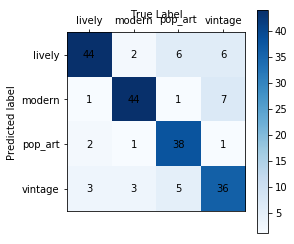

In [9]:
import os
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import gradio
import numpy as np
import gradio.preprocessing_utils
import gradio.inputs
import gradio.outputs
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from google.colab import drive


class StyleClassifier(nn.Module):
    def __init__(self, need_softmax=False):
        super(StyleClassifier, self).__init__()
        self.pre_trained = models.vgg16(pretrained=True)
        self.cnn = nn.Sequential(*list(self.pre_trained.children())[0])
        self.conv_dr = nn.Conv2d(512, 128, 1)
        self.fc = nn.Linear(in_features=128 * 128, out_features=1024)
        self.fc_1 = nn.Linear(in_features=1024, out_features=4)
        self.sig = nn.Sigmoid()
        self.need_softmax = need_softmax

    def get_style_gram(self, style_features):
        style_features = style_features.view(-1, 7 * 7, 128)
        style_features_t = style_features.permute(0, 2, 1)
        grams = []
        for i in range(len(style_features)):
            grams.append(torch.matmul(style_features_t[i], style_features[i]))

        grams = torch.stack(grams, 0)
        grams = grams.view(-1, 128 * 128)

        return grams

    def forward(self, x):
        h = x
        h = self.cnn(h)
        h = self.conv_dr(h)
        
        h = h.permute(0, 2, 3, 1)
        h = self.get_style_gram(h)
        
        h = self.fc(h)
        h = self.fc_1(h)

        if self.need_softmax:
            h = F.log_softmax(h, dim=1)

        return h


def random_data_generator(num):
    result = []
    f = open('/gdrive/My Drive/all.txt', 'r')

    data = f.readlines()
    random.shuffle(data)

    for i, line in enumerate(data):
        if i >= num:
            break
        result.append(line[:-1])

    return result


def target_data_generator(target_tag, num):
    result = []
    f = open('/gdrive/My Drive/all.txt', 'r')

    data = f.readlines()
    random.shuffle(data)

    for line in data:
        if len(result) >= num:
            break
        if line.split('/')[0] == target_tag:
            result.append(line[:-1])

    return result


def get_confusion_matrix(y_pred, y_true, labels):
    matrix = confusion_matrix(y_pred, y_true)
    if len(matrix) != len(labels):
        raise ValueError('The size of parameter labels[%s] is not equal to the size of labels in matrix[%s]'
                         % (str(len(labels)), str(len(matrix))))
    plt.matshow(matrix, cmap=plt.cm.Blues)
    plt.title('True Label', fontsize=10)
    plt.colorbar()
    for x in range(len(matrix)):
        for y in range(len(matrix)):
            plt.annotate(matrix[x][y], xy=(y, x), horizontalalignment='center', verticalalignment='center')

    plt.xticks(range(len(matrix)), labels)
    plt.yticks(range(len(matrix)), labels)

    ax = plt.gca()
    ax.xaxis.set_ticks_position('top')

    ax.set_ylabel('Predicted label')

    return plt


def test(pre_trained_path, labels, sample_per_label):
    data = []
    for item in labels:
        data.extend(target_data_generator(item, sample_per_label))

    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    model = StyleClassifier()

    model.load_state_dict(torch.load(pre_trained_path)['model_state_dict'])

    pred = []

    for item in data:
        im = Image.open(os.path.join('/gdrive/My Drive/style_data_clean', item))
        im = im.convert('RGB')

        predict = model(data_transforms(im).unsqueeze(0)).tolist()[0]

        max_index = 0
        temp_max = predict[0]
        for i in range(1, len(predict)):
            if predict[i] > temp_max:
                temp_max = predict[i]
                max_index = i

        pred.append(max_index)

    data_dict = {}
    for i, item in enumerate(labels):
        data_dict[item] = i

    for i, _ in enumerate(data):
        data[i] = data_dict[data[i].split('/')[0]]

    get_confusion_matrix(pred, data, labels).show()


def image_process(inp):
    im = gradio.preprocessing_utils.decode_base64_to_image(inp)
    im = im.convert('RGB')
    data_transforms_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    im = data_transforms_val(im).unsqueeze(0)

    return im.numpy()


def web_demo(model):
    inp = gradio.inputs.ImageUpload(preprocessing_fn=image_process)
    out = gradio.outputs.Label(label_names=['lively', 'modern', 'pop_art', 'vintage'], num_top_classes=4)
    io = gradio.Interface(inputs=inp, outputs=out, model_type="pytorch", model=model)
    io.launch(inline=True)


if __name__ == '__main__':
    drive.mount('/gdrive')
    pre_trained_model = '/gdrive/My Drive/style_classifier/log/190731_multi.pth.tar'
    
    # get 50 images for each label and draw confusion matrix
    test(pre_trained_model, ['lively', 'modern', 'pop_art', 'vintage'], 50)

    # interactive demo using Gradio
    model = StyleClassifier(need_softmax=True)
    model.load_state_dict(torch.load(pre_trained_model)['model_state_dict'])
    web_demo(model)
